Este notebook realiza uma análise de dados socioeconômicos utilizando técnicas de aprendizado supervisionado e não supervisionado. O objetivo é aprofundar a compreensão das relações entre variáveis socioeconômicas e a taxa de natalidade nos municípios.



In [ ]:
#Importação da bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import seaborn as sns

url = "https://raw.githubusercontent.com/amandacmelo/Projeto-Ciencia-de-Dados/main/dados_limpos.csv"
df = pd.read_csv(url, sep=",")

df.columns


Index(['Ano', 'CDMunicipio', 'Populacao', 'PessoalOcupado',
       'PessoalAssalariado', 'VrSalarios', 'PIB', 'QtEmpresas',
       'AreaPlantada_h', 'AreaColhida_h', 'VlProducaoAgricola',
       'VlProducaoPecuaria', 'Area', 'Importacoes_US$', 'Exportacoes_US$',
       'Receitas_R$', 'Transferencias_correntes_R$',
       'Transferencias_capital_R$', 'NrNascimentos', 'NrObitosInfantis',
       'povoamento', 'UF', 'Municipio', 'Regiao', 'PIB_PerCapita',
       'Densidade_Populacional', 'Proporcao_PessoalAssalariado',
       'Proporcao_Area_Plantada'],
      dtype='object')

# 🟤 **É possível prever o número de nascimentos em municípios a partir de indicadores socioeconômicos?**

Este notebook tem como objetivo aplicar técnicas de aprendizado supervisionado e não supervisionado para analisar a relação entre variáveis socioeconômicas e o número de nascimentos em municípios brasileiros. A escolha dessa pergunta permite explorar diferentes abordagens de modelagem e avaliar o potencial preditivo dos dados disponíveis.

- Etapas desenvolvidas:
      1 - Seleção das variáveis mais relevantes
      2 - Aplicação de aprendizado não supervisionado
      3 - Aplicação de aprendizado supervisionado para variávies categóricas
      4 - Aplicação de aprendizado supervisionado para variávies contínuas
      5 - Conclusão para a pergunta

#**📈 Análise das variáveis**

Para a construção dos modelos, inicialmente foi realizada uma análise gráfica das variáveis socioeconômicas presentes no conjunto de dados, com o objetivo de identificar aquelas que poderiam contribuir para a previsão do número de nascimentos. Seguindo a abordagem discutida em sala de aula, foram observadas as distribuições das variáveis independentes em relação à variável dependente (NrNascimentos).

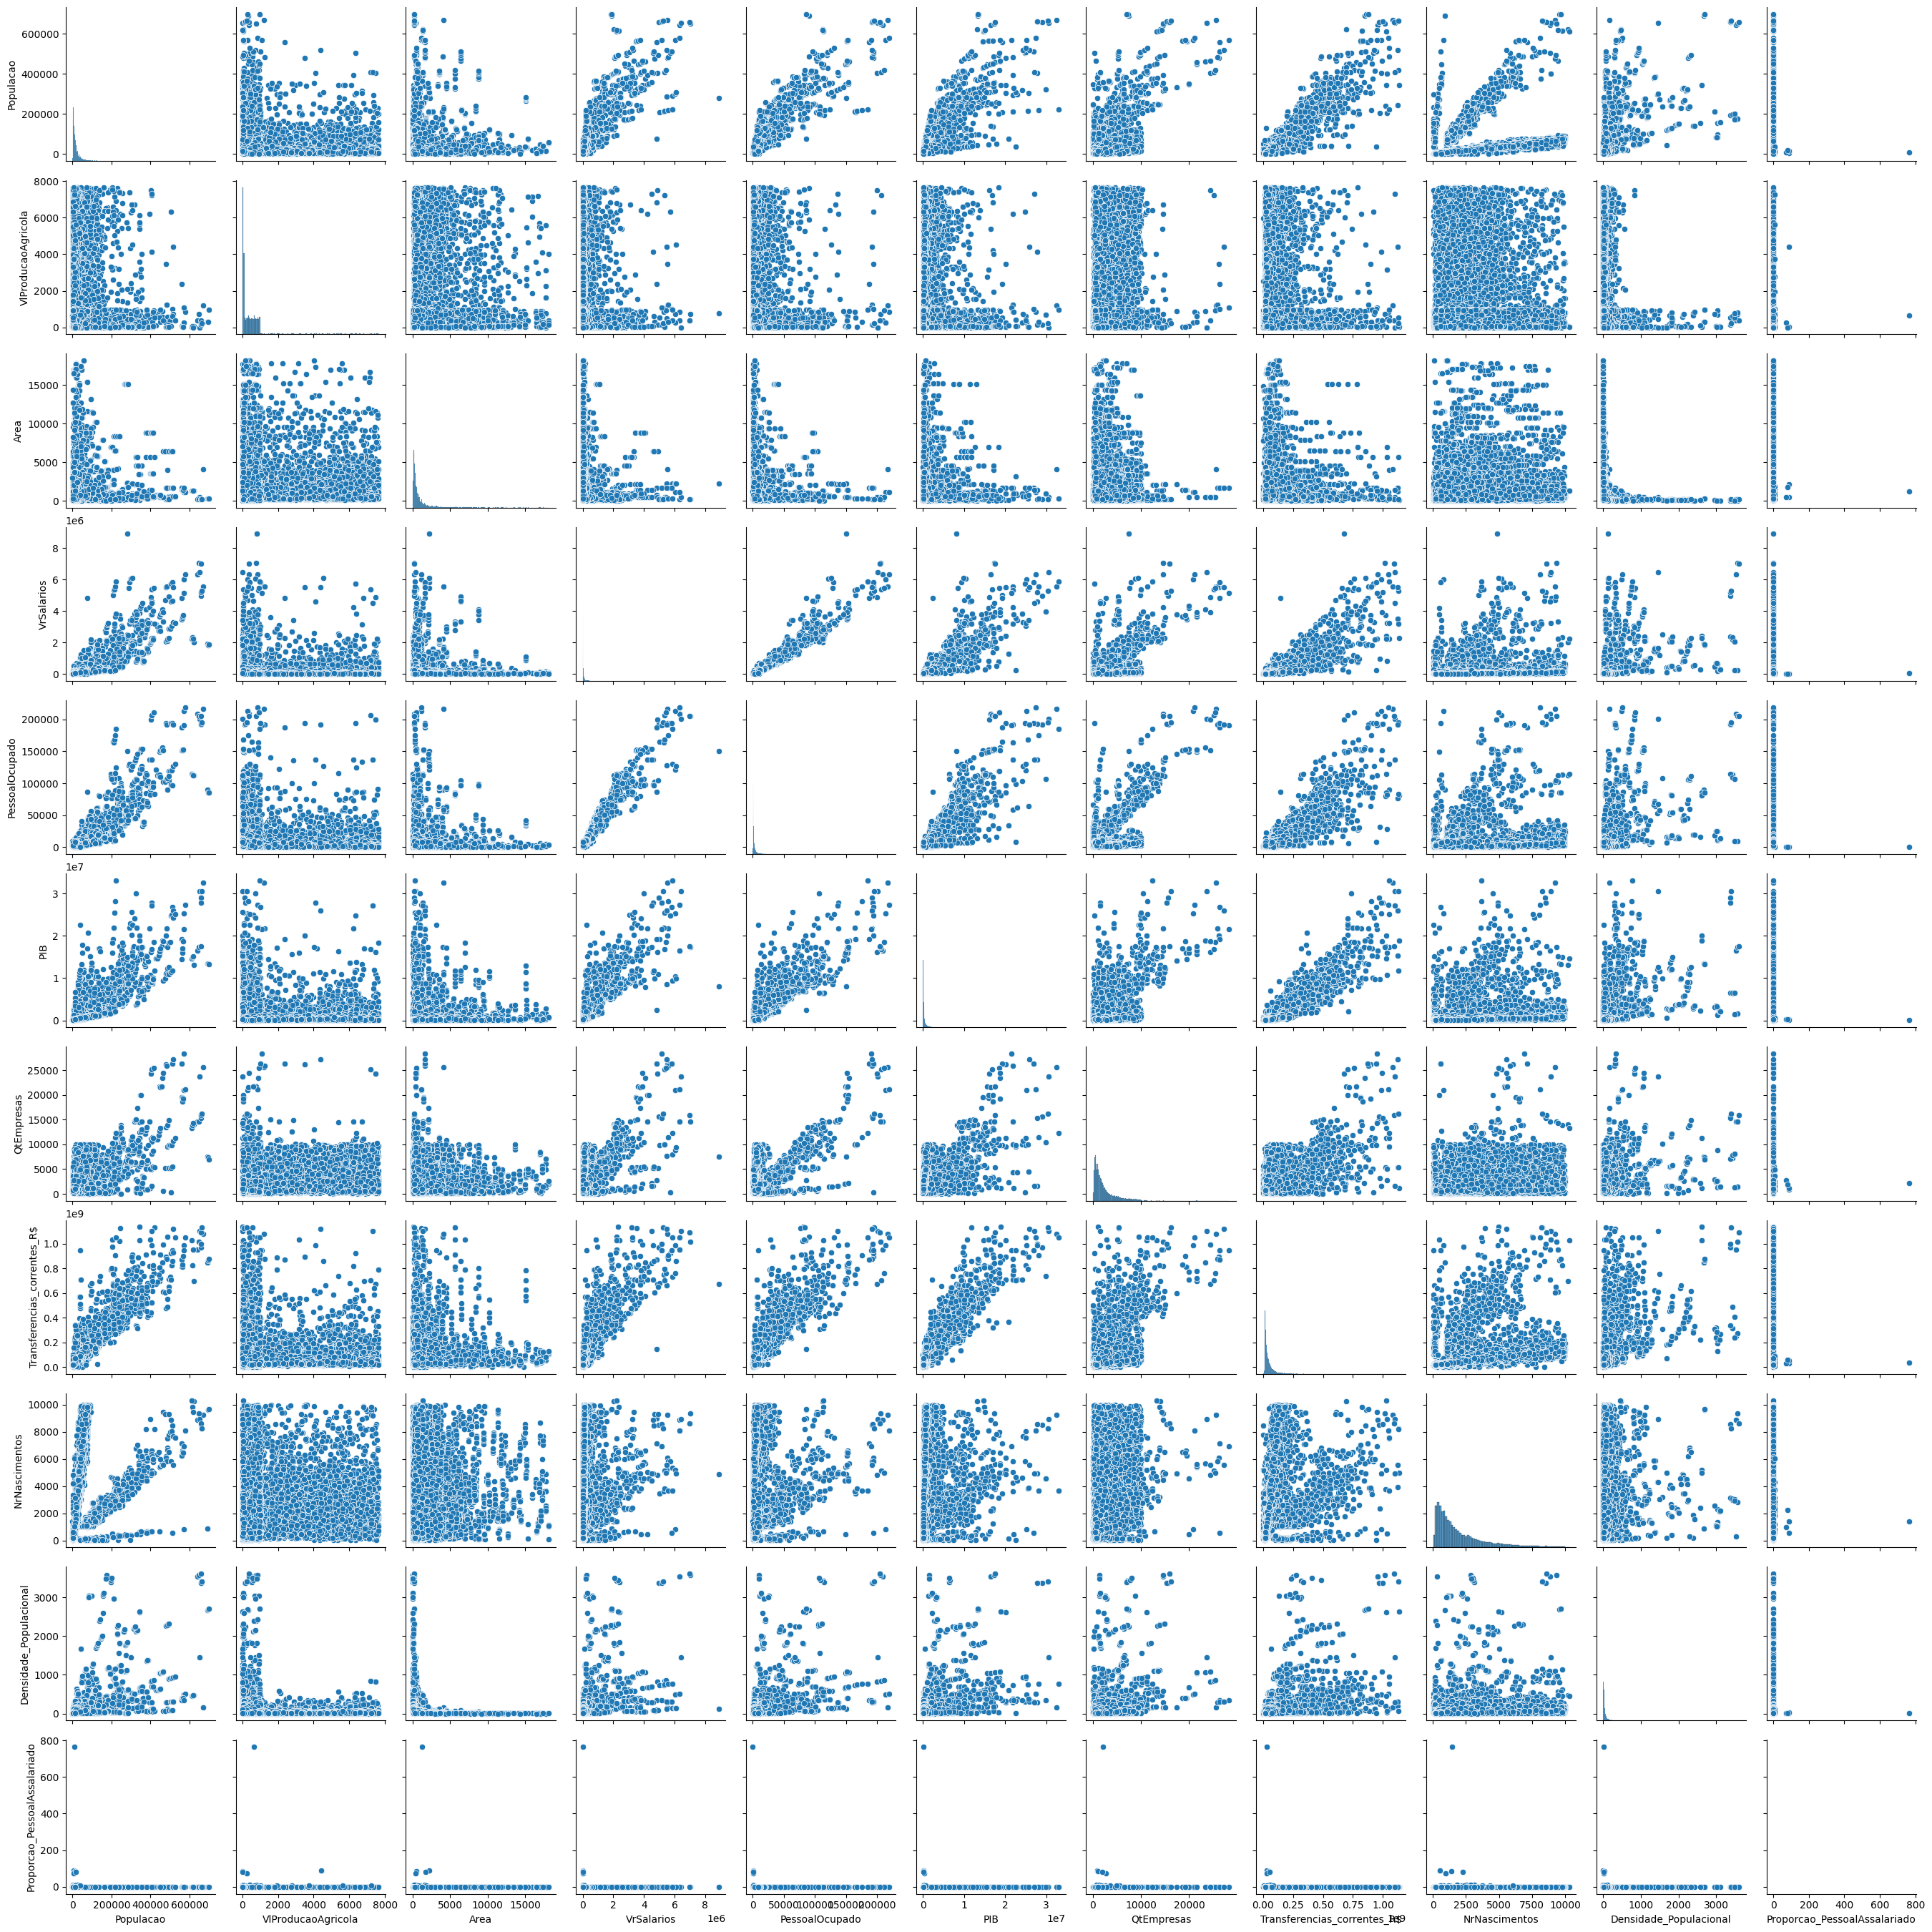

In [ ]:
sns.pairplot(df[[ 'Populacao', 'VlProducaoAgricola', 'Area', 'VrSalarios', 'PessoalOcupado','PIB', 'QtEmpresas', 'Transferencias_correntes_R$', 'NrNascimentos','Densidade_Populacional','Proporcao_PessoalAssalariado']])

### Conclusão:
As variáveis utilizadas foram escolhidas com base em seu impacto social e econômico nos municípios, como PIB, população e salários. Ao analisar os gráficos de dispersão, observamos que a maioria apresenta relações não lineares com o número de nascimentos.

Por isso, optamos pelo uso do Random Forest, que é especialmente eficaz nesse tipo de cenário. O modelo lida bem com não linearidades, interações entre variáveis e outliers, sem necessidade de transformações complexas. Isso o torna uma escolha adequada tanto tecnicamente quanto interpretativamente para esse caso.

# **🔴 Modelo de Aprendizado Não Supervisionado**

Com as variáveis selecionadas, foi aplicada a técnica de aprendizado não supervisionado para identificar agrupamentos de municípios com características socioeconômicas semelhantes.

Antes da clusterização, realizou-se a remoção de outliers por meio do cálculo do z-score das variáveis selecionadas. Valores extremos, como grandes metrópoles que se destacam significativamente dos demais municípios, foram eliminados para evitar que formassem clusters próprios e desequilibrassem o modelo. Foi definido um limite de z-score igual a 3, e observações com valores absolutos acima desse limite em qualquer variável foram removidas. Dados faltantes foram imputados pela mediana.

Em seguida, aplicou-se o algoritmo K-Means para formar 5 clusters baseados nas variáveis filtradas. Para facilitar a visualização, utilizou-se a técnica de PCA (Análise de Componentes Principais) com redução para 2 componentes principais, permitindo representar os dados em um plano bidimensional sem perdas significativas.

Os rótulos dos clusters foram incorporados ao dataframe como uma nova variável categórica, com o intuito de enriquecer o modelo supervisionado subsequente, agregando informação sobre perfis socioeconômicos semelhantes entre os municípios.



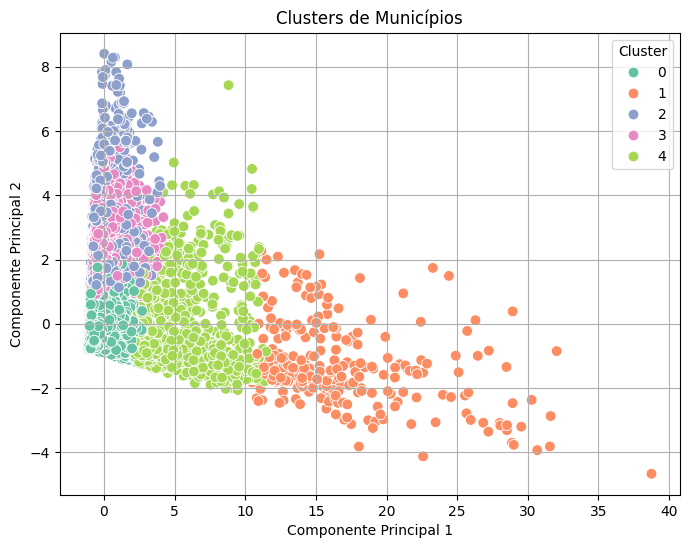


✔️ Silhouette Score (k=5): 0.5890

Distribuição por cluster:
  Cluster 0: 26261 municípios (83.5%)
  Cluster 1: 262 municípios (0.8%)
  Cluster 2: 1137 municípios (3.6%)
  Cluster 3: 2452 municípios (7.8%)
  Cluster 4: 1340 municípios (4.3%)


In [ ]:
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
# Calcular o z-score para todas as variáveis selecionadas

df_cluster = df.copy()
variaveis = [
    'Populacao', 'VlProducaoAgricola', 'Area', 'VrSalarios', 'PessoalOcupado',
    'PIB', 'QtEmpresas', 'Transferencias_correntes_R$'
]

z_scores = df_cluster[variaveis].apply(zscore)

# Definir limite para detectar outliers
limite = 3
df_cluster[variaveis] = df_cluster[variaveis].fillna(df_cluster[variaveis].median())
# Filtrar linhas que não possuem nenhum z-score fora do limite
df_filtrado = df_cluster[(np.abs(z_scores) < limite).all(axis=1)].copy()
df_cluster = df_cluster.loc[(df_cluster[variaveis] != 0).all(axis=1)].copy()

# Escalar os dados filtrados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_filtrado[variaveis])

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# KMeans com k clusters (ex: 3)
k = 5
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
labels = kmeans.fit_predict(X_scaled)

# Adicionar resultados ao DataFrame
df_filtrado['cluster'] = labels
df_filtrado['PCA1'] = X_pca[:, 0]
df_filtrado['PCA2'] = X_pca[:, 1]
df =  df_filtrado.copy()

# Visualizar clusters
plt.figure(figsize=(8,6))
sns.scatterplot(data=df_filtrado, x='PCA1', y='PCA2', hue='cluster', palette='Set2', s=60)
plt.title(f'Clusters de Municípios')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

# Silhouette score
print(f"\n✔️ Silhouette Score (k={k}): {silhouette_score(X_scaled, labels):.4f}")

# Distribuição dos clusters
print(f"\nDistribuição por cluster:")
for i in sorted(df_filtrado['cluster'].unique()):
    n = (df_filtrado['cluster'] == i).sum()
    print(f"  Cluster {i}: {n} municípios ({n / len(df_filtrado) * 100:.1f}%)")


### Conclusão:
A análise de agrupamento (clustering) dos municípios, permitiu identificar padrões distintos entre os municípios. O resultado apresentou uma Silhouette de 0,5890, indicando uma separação razoável entre os grupos formados. Valores de Silhouette entre 0,5 e 0,7 podem considerados bons e revelam clusters bem definidos, com pouca sobreposição.

A maior parte dos municípios (83,5%) foi agrupada no Cluster 0, sugerindo que muitos municípios compartilham características similares nas variáveis analisadas. Em contrapartida, os demais clusters — especialmente os Clusters 1, 2, 3 e 4 — representam grupos menores de municípios com perfis mais específicos ou diferenciados.

Esses resultados demonstram que a segmentação promoveu uma divisão clara e bem definida dos municípios, evidenciando a predominância de um perfil comum em grande parte deles, ao mesmo tempo em que identificou grupos com características socioeconômicas distintas.



## **📊 Análise das Médias por Cluster**
A tabela a seguir apresenta as **médias das variáveis numéricas** para cada um dos clusters gerados pelo algoritmo K-Means. Essa análise permite compreender melhor as características socioeconômicas predominantes em cada grupo de municípios e entender **por que determinados grupos se formaram com certas quantidades de municípios**.

In [ ]:
# Médias por cluster
cluster_means = df.groupby('cluster').mean(numeric_only=True)
print(cluster_means.T)


cluster                                  0             1             2  \
Ano                           2.018447e+03  2.018233e+03  2.018441e+03   
CDMunicipio                   3.198386e+06  3.451919e+06  2.766349e+06   
Populacao                     1.528576e+04  3.784913e+05  3.140898e+04   
PessoalOcupado                2.164100e+03  1.168444e+05  3.338226e+03   
PessoalAssalariado            1.827837e+03  9.993316e+04  2.842286e+03   
VrSalarios                    4.507971e+04  3.543108e+06  7.256023e+04   
PIB                           2.518400e+05  1.368810e+07  5.787399e+05   
QtEmpresas                    1.860701e+03  1.094331e+04  2.282122e+03   
AreaPlantada_h                1.414767e+02  3.539313e+02  9.088399e+02   
AreaColhida_h                 1.431294e+02  3.294275e+02  8.989455e+02   
VlProducaoAgricola            3.131498e+02  9.472863e+02  1.184545e+03   
VlProducaoPecuaria            1.852488e+02  4.635115e+02  2.171416e+02   
Area                          6.449273

### Conclusão:
A análise das médias das variáveis por cluster evidencia **perfis socioeconômicos distintos** entre os grupos formados, justificando a segmentação realizada pelo algoritmo K-Means.

- **Cluster 0:** Representa a maioria dos municípios, caracterizados por **baixos indicadores socioeconômicos**, como menor população, menor número de empresas e PIB reduzido. Isso indica a concentração de municípios de pequeno porte, sendo o perfil típico da maior parte dos municípios brasileiros.

- **Cluster 1:** Agrupa um número muito menor de municípios, mas com **valores significativamente superiores em praticamente todas as variáveis**. Dessa maneira, pode se concluir que são cidades grandes, com alta população, elevado PIB, número expressivo de empresas, ou seja, **grandes centros urbanos ou capitais**.

- **Cluster 2:** Apresenta um perfil intermediário, com destaque para a **produção agrícola**, indicando municípios com maior extensão territorial e atividade no setor agropecuário.

- **Cluster 3:** Reúne municípios também de porte médio, com destaque para **altos valores de produção agrícola e pecuária**, porém com menor densidade populacional.

- **Cluster 4:** Possui características mistas, municípios com **população moderada a alta**, bons indicadores de PIB e receitas, além de níveis médios em agropecuária e densidade. Assim, esse grupo pode representar **cidades médias em crescimento ou com economia diversificada**.

Essa segmentação demonstra que o modelo foi eficaz em dividir os municípios de forma **coerente**, com cada cluster representando um perfil socioeconômico bem definido.

# **🔵 Modelo de Aprendizado Supervisionado - Dados Categóricos**

Nesta etapa, foi utilizado o algoritmo RandomForestClassifier para prever a faixa de número de nascimentos dos municípios, classificada em baixo, médio e alto.

Para isso, foram criadas variáveis (lag1, lag2, lag3) que representam os nascimentos em anos anteriores, além de selecionadas variáveis socioeconômicas como PIB, população e salários. Também foi incluído o cluster de cada município, obtido na etapa anterior, como variável preditora.

Os dados foram divididos respeitando a ordem temporal: os anos até 2019 foram usados para treino, e os anos seguintes para teste, perimitindo assim avaliar o desempenho para cada classe.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
# 1. Criar lags
df = df.sort_values(['CDMunicipio', 'Ano']).reset_index(drop=True)
df['lag1'] = df.groupby('CDMunicipio')['NrNascimentos'].shift(1)
df['lag2'] = df.groupby('CDMunicipio')['NrNascimentos'].shift(2)
df['lag3'] = df.groupby('CDMunicipio')['NrNascimentos'].shift(3)

# 2. Criar classe de saída
df['classe_nascimentos'] = pd.qcut(df['NrNascimentos'], q=3, labels=['baixo', 'medio', 'alto'])

# 3. Remover NaNs causados pelos lags
df_modelo = df.dropna().reset_index(drop=True)

# 4. Features e alvo
features = ['lag1', 'lag2', 'lag3', 'PIB', 'Populacao', 'VrSalarios', 'cluster']
X = df_modelo[features]
y = df_modelo['classe_nascimentos']

# 5. Separar treino e teste com base no tempo
treino = df_modelo[df_modelo['Ano'] <= 2019]
teste = df_modelo[df_modelo['Ano'] > 2019]

X_train = treino[features]
y_train = treino['classe_nascimentos']
X_test = teste[features]
y_test = teste['classe_nascimentos']

# 6. Treinamento
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# 7. Avaliação
from sklearn.metrics import classification_report
y_pred = clf.predict(X_test)

# Relatório
print("Relatório de Classificação:\n")
print(classification_report(y_test, y_pred))


Relatório de Classificação:

              precision    recall  f1-score   support

        alto       0.94      0.96      0.95      3260
       baixo       0.94      0.92      0.93      3503
       medio       0.89      0.89      0.89      3376

    accuracy                           0.92     10139
   macro avg       0.92      0.92      0.92     10139
weighted avg       0.92      0.92      0.92     10139



### Conclusão:
O modelo apresentou acurácia de 92%, com bom desempenho em todas as classes. As faixas "alto" e "baixo" tiveram f1-scores acima de 93%, enquanto a classe "médio" alcançou 89%, um valor esperado, já que as observações dessa faixa tendem a ser mais próximas dos limites das classes vizinhas, o que naturalmente dificulta a classificação precisa.

Esses resultados indicam que o modelo conseguiu prever com precisão a faixa de número de nascimentos, aproveitando bem as informações históricas e socioeconômicas disponíveis.


## **📊 Matriz de confusão**

A matriz de confusão foi construída para avaliar o desempenho do modelo de forma visual e prática, permitindo aplicar na análise real os conceitos estudados em sala de aula. Ela compara, para cada classe (baixo, médio e alto), a quantidade de previsões corretas e incorretas, evidenciando onde o modelo acerta e onde apresenta erros.

Também foi gerado um mapa de calor da matriz, que destaca os acertos (valores na diagonal principal) e os erros (valores fora da diagonal), facilitando a identificação das classes em que o modelo tem melhor ou pior desempenho e promovendo uma compreensão mais detalhada do funcionamento do classificador.

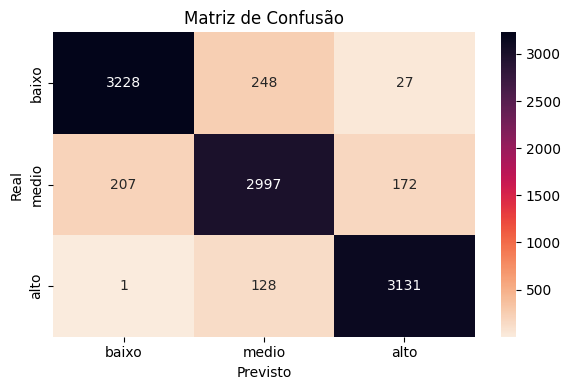

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix


# Matriz de confusão
cm = confusion_matrix(y_test, y_pred, labels=['baixo', 'medio', 'alto'])
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='rocket_r',
            xticklabels=['baixo', 'medio', 'alto'],
            yticklabels=['baixo', 'medio', 'alto'])
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.tight_layout()
plt.show()


### Conclusão:
O modelo teve bom desempenho geral, mas, como mencionado anteriormente, a classe “médio” apresentou mais confusõe indicando uma menor precisão nesse grupo.

# **🟣 Modelo de Aprendizado Supervisionado - Valores Contínuos**

Para prever o número de nascimentos nos municípios, foi utilizado um modelo de regressão baseadono algoritmo Random Forest. Foram selecionadas variáveis socioeconômicas relevantes, como PIB, população, salário, além do cluster gerado pelo modelo de agrupamento não supervisionado, para capturar diferentes perfis dos municípios.

Os dados foram divididos em conjuntos de treino e teste para avaliar o desempenho do modelo em dados novos. Além disso, aplicou-se validação cruzada para garantir a robustez dos resultados.

O objetivo dessa abordagem foi combinar variáveis econômicas e sociais com os agrupamentos identificados para melhorar a capacidade preditiva do modelo, validando assim a relação entre indicadores socioeconômicos e o número de nascimentos.

[Avaliação no Teste]
MAE: 454.94
R²: 0.7911


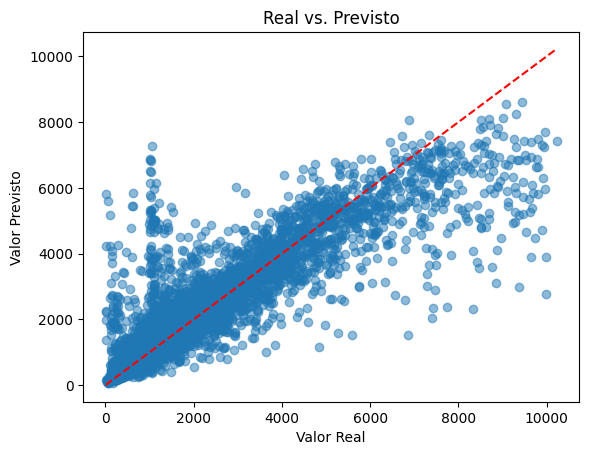

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_absolute_error, r2_score, make_scorer

features = [
    'Ano',
    'PIB', # ve se pode
    'PessoalOcupado',
    'QtEmpresas',
    'VrSalarios',
    'PIB_PerCapita',
    'Densidade_Populacional',
    'Proporcao_PessoalAssalariado',
    'cluster'
]

X = df[features]
y = df['NrNascimentos']

# Dividir treino e teste para visualização do gráfico
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelo
reg = RandomForestRegressor(random_state=42)
reg.fit(X_train, y_train)

# Previsão no conjunto de teste
y_pred = reg.predict(X_test)

# Avaliação básica
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"[Avaliação no Teste]")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.4f}")

# Visualização
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Valor Real')
plt.ylabel('Valor Previsto')
plt.title('Real vs. Previsto')
plt.show()

# --- Validação Cruzada (5-fold) ---

cv = KFold(n_splits=5, shuffle=True, random_state=42)

# R² médio
r2_scores = cross_val_score(reg, X, y, cv=cv, scoring='r2')
print(f"\n[R² - Validação Cruzada 5-fold]")
print(f"R² por fold: {np.round(r2_scores, 4)}")
print(f"R² médio: {r2_scores.mean():.4f}")

# MAE médio
mae_scores = cross_val_score(reg, X, y, cv=cv, scoring=make_scorer(mean_absolute_error))
print(f"\n[MAE - Validação Cruzada 5-fold]")
print(f"MAE por fold: {np.round(mae_scores, 2)}")
print(f"MAE médio: {mae_scores.mean():.2f}")

### Conclusão:  

O modelo gressão obteve um desempenho consistente, com R² = 0.7844 no teste e erro médio absoluto (MAE) de 461,59, indicando boa capacidade preditiva. A validação cruzada 5-fold reforça essa estabilidade, com um R² médio de 0.7789 e MAE médio de 463.57, valores próximos aos observados no conjunto de teste. O gráfico “Real vs. Previsto” mostra uma forte correlação, embora existam alguns desvios maiores em valores extremos. De forma geral, o modelo é eficaz para estimar os valores reais, mantendo baixo erro médio e boa generalização.



## 🔍 Análise dos Erros de Previsão

Para explorar ainda mais os resultados do modelo de regressão, foi criada uma análise comparando os valores reais e previstos para cada município no conjunto de teste. Calculou-se o erro absoluto das previsões e ordenou-se os resultados para identificar os casos com maior e menor precisão.


In [ ]:
# Criar DataFrame com Ano e Municipio dos dados de teste
df_test_info = df.loc[X_test.index, ['Ano', 'Municipio']].copy()

# Adicionar as colunas Real (y_test) e Previsto (y_pred)
df_test_info['Real'] = y_test.values
df_test_info['Previsto'] = y_pred

# Calcular erro absoluto
df_test_info['Erro_Absoluto'] = abs(df_test_info['Real'] - df_test_info['Previsto'])

# Ordenar do menor para o maior erro
df_ordenado = df_test_info.sort_values(by='Erro_Absoluto')

# Mostrar as 5 melhores previsões (menor erro)
print("🔹 5 Melhores Previsões:")
print(df_ordenado.head(5))

# Mostrar as 5 piores previsões (maior erro)
print("\n🔸 5 Piores Previsões:")
print(df_ordenado.tail(5))


🔹 5 Melhores Previsões:
        Ano              Municipio  Real  Previsto  Erro_Absoluto
3263   2017  Santa Rita do Sapucaí  5290   5289.94           0.06
14682  2017     Santa Clara do Sul   770    770.30           0.30
11080  2021                  Tapes  1460   1459.70           0.30
30697  2020     Bonito de Santa Fé  1480   1480.50           0.50
21378  2016              Mampituba   340    340.70           0.70

🔸 5 Piores Previsões:
        Ano              Municipio  Real  Previsto  Erro_Absoluto
5290   2018                 Russas  1001   8389.78        7388.78
6237   2019      Benjamin Constant   103   7577.90        7474.90
12475  2021             Moji-Mirim  9410   1850.92        7559.08
10092  2020             Moji-Mirim  9440   1470.51        7969.49
10108  2020  São João da Boa Vista  9910   1381.12        8528.88


### Conclusão:
A análise dos erros de previsão permitiu identificar exemplos concretos do desempenho do modelo. As 5 melhores previsões apresentam erros praticamente nulos, mostrando que, para determinados municípios e anos, o modelo conseguiu capturar bem os padrões dos dados.

Por outro lado, as 5 piores previsões evidenciam situações com grande divergência entre o valor real e o previsto. Esses casos indicam a presença de municípios com características atípicas ou variações bruscas no número de nascimentos, que o modelo não foi capaz de generalizar com precisão.

# 🟤 **Conclusão Para a Pergunta**
Os resultados mostram que é possível prever o número de nascimentos em municípios com base em indicadores socioeconômicos. O uso de clustering foi fundamental para identificar padrões entre os municípios e gerou uma nova variável (o cluster), que enriqueceu o modelo supervisionado ao representar grupos socioeconômicos similares.

Com bons resultados de acurácia e validação cruzada, conclui-se que as variáveis socioeconômicas são relevantes para estimar o comportamento demográfico local, evidenciando o potencial dos dados socioeconômicos para apoiar políticas públicas e estudos populacionais.